# <font style="font-size:40px"><center><b>Machine Learning</b></center></font><font                        style="font-size:30px"><center><b>Master in Computational Finance (MCF) </b></center></font> 

<center> 

# 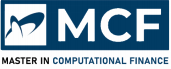

<center/>

# <font color='tomato' style="font-size:40px"><center><b>Final Exam</b></center></font></b></center></font> 

<center>
<b>profesor: </b> Nikola Vasiljevic

<b>students: </b> 
Nikola Krivacevic, Aleksandar Milinkovic
</center>





# Preliminaries

In [1]:
# Import / install relevant Python packages
import numpy as np
from numpy import (where, unique)
import pandas as pd

from sklearn.metrics import silhouette_samples
from sklearn.cluster import (KMeans, MiniBatchKMeans, AgglomerativeClustering, DBSCAN)
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors

from collections import Counter
from sklearn import metrics

from scipy.cluster.hierarchy import (linkage, dendrogram, set_link_color_palette)

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.style.use('ggplot')
import seaborn as sns


# 1 Clustering 

Consider the Federal Reserve Bank of St. Louis’ monthly database of macroeconomic
factors created by Michael W. McCracken et al. The data and the associated research paper
(McCracken and Ng, 2016) are available on the shared drive in the folders ‘Homework’ and
‘Readings’, respectively. The list of all variables and the respective recommended data
transformations are listed in the appendix of the paper (pp. 586–588).
The goal of this exercise to to apply various clustering techniques on FRED–MD dataset,
and to compare the results with the classification of macroeconomic variables proposed in
McCracken and Ng (2016).

## (a) Data preprocessing

Starting from your earlier results for data preprocessing
(see Machine Learning Homework 2), discuss and implement any additional data
transformations—on top of those suggested in McCracken and Ng (2016)—that are
required in order to apply clustering methods on the FRED–MD dataset. (3 pts)

**NOTE:** Majority of the code for preprocessing is copied/inherited form Homework 2. However, there are some aditional steps in the preprocessing. For more detailed information and diagrams, please refer to Homework 2.

First of all, we are going to define helper functions (same like Homework 2) for data transformation and outlier coping.

In [2]:
# Helper functions
def transform(dataframe, feature, tcode):
  if tcode == 1:
    return dataframe[feature]
  if tcode == 2:
    return dataframe[feature] - dataframe[feature].shift(1)
  if tcode == 3:
    return (dataframe[feature] - dataframe[feature].shift(1)) - (dataframe[feature].shift(1) - dataframe[feature].shift(2))
  if tcode == 4:
    return np.log(dataframe[feature])
  if tcode == 5:
    return np.log(dataframe[feature]) - np.log(dataframe[feature].shift(1))
  if tcode == 6:
    return (np.log(dataframe[feature]) - np.log(dataframe[feature].shift(1))) - (np.log(dataframe[feature]).shift(1) - np.log(dataframe[feature].shift(2)))
  if tcode == 7:
    return (dataframe[feature]/dataframe[feature].shift(1) - 1) - (dataframe[feature].shift(1)/dataframe[feature].shift(2) -1)

def update_outliers(dataframe, feature):
  feature_data = dataframe[feature]
  Q1 = feature_data.quantile(0.25)
  Q3 = feature_data.quantile(0.75)
  IQR = Q3-Q1
  maximum = Q3+1.5*IQR
  minimum = Q1-1.5*IQR
  dataframe.loc[dataframe[feature]>maximum, feature] = maximum
  dataframe.loc[dataframe[feature]<minimum, feature] = minimum


Loading the data that was given:

In [3]:
df = pd.read_csv("McCracken_Macro_Dataset_Monthly.csv")
df

,sasdate,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,IPNCONGD,IPBUSEQ,IPMAT,IPDMAT,IPNMAT,IPMANSICS,IPB51222S,IPFUELS,CUMFNS,HWI,HWIURATIO,CLF16OV,CE16OV,UNRATE,UEMPMEAN,UEMPLT5,UEMP5TO14,UEMP15OV,UEMP15T26,UEMP27OV,CLAIMSx,PAYEMS,USGOOD,CES1021000001,USCONS,MANEMP,DMANEMP,NDMANEMP,SRVPRD,...,TB3SMFFM,TB6SMFFM,T1YFFM,T5YFFM,T10YFFM,AAAFFM,BAAFFM,TWEXAFEGSMTHx,EXSZUSx,EXJPUSx,EXUSUKx,EXCAUSx,WPSFD49207,WPSFD49502,WPSID61,WPSID62,OILPRICEx,PPICMM,CPIAUCSL,CPIAPPSL,CPITRNSL,CPIMEDSL,CUSR0000SAC,CUSR0000SAD,CUSR0000SAS,CPIULFSL,CUSR0000SA0L2,CUSR0000SA0L5,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
0,Transform:,5.000,5.0,5.000,5.000000e+00,5.00000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,2.0000,2.0,2.000000,5,5,2.0,2.0,5,5,5,5,5,5,5,5,5.0,5,5,5,5,5,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,5.0000,5.0000,5.0000,5.0000,5.0000,6.0,6.0,6.0,6.0,6.00,6.0,6.000,6.000,6.000,6.000,6.000,6.000,6.000,6.000,6.000,6.000,6.000,6.000,6.000,6.000,6.00,6.00,6.00,2.0,6.00,6.00,6.0000,1.0000
1,01/01/1959,2442.158,2293.2,17.272,2.922664e+05,18235.77392,22.0733,23.4027,22.2858,31.5688,18.6601,38.1454,8.1760,20.2407,12.2794,30.6469,20.9189,19.9060,34.7139,80.1973,1357.0,0.333579,67936,63868,6.0,16.3,1574,1169,1396,594,802,291078,52478,18796,713.0,2993,14998,8740,6258,33682,...,0.34,0.61,0.88,1.53,1.54,1.64,2.39,NaN,4.3122,359.8417,2.8065,0.9671,33.1,33.4,30.6,31.6,3.00,32.5,29.010,44.800,29.300,21.100,33.300,38.100,22.900,28.900,30.700,29.600,16.042,56.918,17.791,11.326,2.13,2.45,2.04,NaN,6476.00,12298.00,84.2043,NaN
2,02/01/1959,2451.778,2301.5,17.452,2.944247e+05,18369.56308,22.5056,23.7185,22.4788,31.8004,18.7580,38.5100,8.2854,20.8817,12.8450,31.1834,21.3034,19.8518,34.2411,81.4428,1421.0,0.358386,67649,63684,5.9,15.5,1554,1164,1277,545,732,282958,52688,18890,704.2,2980,15115,8839,6276,33798,...,0.27,0.70,1.11,1.53,1.53,1.71,2.46,NaN,4.3133,359.8417,2.8093,0.9748,33.2,33.4,30.7,31.4,3.00,32.5,29.000,44.700,29.400,21.200,33.300,38.100,23.000,28.900,30.700,29.600,16.057,56.951,17.798,11.343,2.14,2.46,2.05,NaN,6476.00,12298.00,83.5280,NaN
3,03/01/1959,2467.594,2318.5,17.617,2.934187e+05,18523.05762,22.8298,23.8621,22.5892,31.8004,19.1254,38.3277,8.3749,21.4240,13.3511,31.6519,21.6367,19.9873,35.1079,82.4769,1524.0,0.400947,68068,64267,5.6,15.3,1459,1093,1210,530,680,260346,53014,19069,704.1,3013,15259,8965,6294,33945,...,0.00,0.33,0.81,1.19,1.19,1.33,2.05,NaN,4.3228,359.8417,2.8127,0.9698,33.2,33.3,30.7,31.5,2.97,32.9,28.970,44.700,29.600,21.300,33.200,38.300,23.000,28.900,30.700,29.600,16.068,57.022,17.785,11.363,2.15,2.45,2.07,NaN,6508.00,12349.00,81.6405,NaN
4,04/01/1959,2483.671,2334.9,17.553,2.993228e+05,18534.46600,23.3161,24.2067,22.9201,32.3021,19.2478,38.9658,8.5937,22.0157,13.7530,32.6322,22.0981,20.0685,34.9503,83.9922,1589.0,0.444973,68339,64768,5.2,14.9,1494,934,1039,408,631,246413,53321,19269,705.2,3085,15385,9077,6308,34052,...,-0.01,0.31,0.76,1.16,1.16,1.27,1.90,NaN,4.3226,359.8417,2.8165,0.9636,33.2,33.4,30.7,31.7,2.97,32.7,28.980,44.800,29.700,21.300,33.200,38.300,23.100,29.000,30.700,29.600,16.100,57.080,17.796,11.403,2.16,2.47,2.08,NaN,6620.00,12484.00,81.8099,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,04/01/2021,18261.337,14130.6,123.827,1.585555e+06,628751.00000,99.2301,98.3032,98.9459,99.4073,99.2308,99.3852,92.3234,100.2550,95.9528,98.3618,97.4914,106.4134,92.4188,75.0321,9193.0,0.936914,160988,151176,6.1,28.8,2414,1939,5386,1203,4183,621000,144326,20319,571.4,7439,12264,7605,4659,124007,...,-0.05,-0.03,-0.01,0.79,1.56,2.83,3.53,103.8470,0.9218,109.0445,1.38

Storing the transformation codes into separate array:

In [4]:
df_transformations = df.iloc[0]
df.drop(index=df.index[0], axis=0, inplace=True)

df_transformations

sasdate            Transform:
RPI                         5
W875RX1                     5
DPCERA3M086SBEA             5
CMRMTSPLx                   5
                      ...    
UMCSENTx                    2
DTCOLNVHFNM                 6
DTCTHFNM                    6
INVEST                      6
VXOCLSx                     1
Name: 0, Length: 128, dtype: object

Now, our dataframe looks like this:

In [5]:
df = df.set_index('sasdate')
df.index.rename('', inplace=True)
df

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,IPNCONGD,IPBUSEQ,IPMAT,IPDMAT,IPNMAT,IPMANSICS,IPB51222S,IPFUELS,CUMFNS,HWI,HWIURATIO,CLF16OV,CE16OV,UNRATE,UEMPMEAN,UEMPLT5,UEMP5TO14,UEMP15OV,UEMP15T26,UEMP27OV,CLAIMSx,PAYEMS,USGOOD,CES1021000001,USCONS,MANEMP,DMANEMP,NDMANEMP,SRVPRD,USTPU,...,TB3SMFFM,TB6SMFFM,T1YFFM,T5YFFM,T10YFFM,AAAFFM,BAAFFM,TWEXAFEGSMTHx,EXSZUSx,EXJPUSx,EXUSUKx,EXCAUSx,WPSFD49207,WPSFD49502,WPSID61,WPSID62,OILPRICEx,PPICMM,CPIAUCSL,CPIAPPSL,CPITRNSL,CPIMEDSL,CUSR0000SAC,CUSR0000SAD,CUSR0000SAS,CPIULFSL,CUSR0000SA0L2,CUSR0000SA0L5,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01/01/1959,2442.158,2293.2,17.272,2.922664e+05,18235.77392,22.0733,23.4027,22.2858,31.5688,18.6601,38.1454,8.1760,20.2407,12.2794,30.6469,20.9189,19.9060,34.7139,80.1973,1357.0,0.333579,67936,63868,6.0,16.3,1574,1169,1396,594,802,291078,52478,18796,713.0,2993,14998,8740,6258,33682,10774,...,0.34,0.61,0.88,1.53,1.54,1.64,2.39,NaN,4.3122,359.8417,2.8065,0.9671,33.1,33.4,30.6,31.6,3.00,32.5,29.010,44.800,29.300,21.100,33.300,38.100,22.900,28.900,30.700,29.600,16.042,56.918,17.791,11.326,2.13,2.45,2.04,NaN,6476.00,12298.00,84.2043,NaN
02/01/1959,2451.778,2301.5,17.452,2.944247e+05,18369.56308,22.5056,23.7185,22.4788,31.8004,18.7580,38.5100,8.2854,20.8817,12.8450,31.1834,21.3034,19.8518,34.2411,81.4428,1421.0,0.358386,67649,63684,5.9,15.5,1554,1164,1277,545,732,282958,52688,18890,704.2,2980,15115,8839,6276,33798,10816,...,0.27,0.70,1.11,1.53,1.53,1.71,2.46,NaN,4.3133,359.8417,2.8093,0.9748,33.2,33.4,30.7,31.4,3.00,32.5,29.000,44.700,29.400,21.200,33.300,38.100,23.000,28.900,30.700,29.600,16.057,56.951,17.798,11.343,2.14,2.46,2.05,NaN,6476.00,12298.00,83.5280,NaN
03/01/1959,2467.594,2318.5,17.617,2.934187e+05,18523.05762,22.8298,23.8621,22.5892,31.8004,19.1254,38.3277,8.3749,21.4240,13.3511,31.6519,21.6367,19.9873,35.1079,82.4769,1524.0,0.400947,68068,64267,5.6,15.3,1459,1093,1210,530,680,260346,53014,19069,704.1,3013,15259,8965,6294,33945,10873,...,0.00,0.33,0.81,1.19,1.19,1.33,2.05,NaN,4.3228,359.8417,2.8127,0.9698,33.2,33.3,30.7,31.5,2.97,32.9,28.970,44.700,29.600,21.300,33.200,38.300,23.000,28.900,30.700,29.600,16.068,57.022,17.785,11.363,2.15,2.45,2.07,NaN,6508.00,12349.00,81.6405,NaN
04/01/1959,2483.671,2334.9,17.553,2.993228e+05,18534.46600,23.3161,24.2067,22.9201,32.3021,19.2478,38.9658,8.5937,22.0157,13.7530,32.6322,22.0981,20.0685,34.9503,83.9922,1589.0,0.444973,68339,64768,5.2,14.9,1494,934,1039,408,631,246413,53321,19269,705.2,3085,15385,9077,6308,34052,10905,...,-0.01,0.31,0.76,1.16,1.16,1.27,1.90,NaN,4.3226,359.8417,2.8165,0.9636,33.2,33.4,30.7,31.7,2.97,32.7,28.980,44.800,29.700,21.300,33.200,38.300,23.100,29.000,30.700,29.600,16.100,57.080,17.796,11.403,2.16,2.47,2.08,NaN,6620.00,12484.00,81.8099,NaN
05/01/1959,2498.026,2350.4,17.765,3.013643e+05,18679.66354,23.6673,24.4077,23.1408,32.4565,19.6396,38.9658,8.8722,22.5828,14.2293,32.9253,22.4058,20.3664,34.2805,84.9159,1655.0,0.475711,68178,64699,5.1,14.7,1479,1005,965,390,575,246952,53550,19378,710.0,3087,15487,9160,6327,34172,10949,...,-0.06,0.43,1.06,1.45,1.41,1.47,2.06,NaN,4.3228,359.8417,2.8145,0.9630,33.3,33.3,30.9,31.5,2.97,32.9,29.040,44.900,29.700,21.400,33.300,38.400,23.200,29.100,30.700,29.600,16.109,57.175,17.777,11.421,2.17,2.48,2.08,95.3,6753.00,12646.00,80.7315,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
04/01/2021,18261.337,14130.6,123.827,1.585555e+06,628751.00000,99.2301,98.3032,98.9459,99.4073,99.2308,99.3852,92.3234,100.2550,95.9528,98.3618,97.4914,106.4134,92.4

Taking a quick look at statistical information:

In [6]:
df.describe()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,IPNCONGD,IPBUSEQ,IPMAT,IPDMAT,IPNMAT,IPMANSICS,IPB51222S,IPFUELS,CUMFNS,HWI,HWIURATIO,CLF16OV,CE16OV,UNRATE,UEMPMEAN,UEMPLT5,UEMP5TO14,UEMP15OV,UEMP15T26,UEMP27OV,CLAIMSx,PAYEMS,USGOOD,CES1021000001,USCONS,MANEMP,DMANEMP,NDMANEMP,SRVPRD,USTPU,...,TB3SMFFM,TB6SMFFM,T1YFFM,T5YFFM,T10YFFM,AAAFFM,BAAFFM,TWEXAFEGSMTHx,EXSZUSx,EXJPUSx,EXUSUKx,EXCAUSx,WPSFD49207,WPSFD49502,WPSID61,WPSID62,OILPRICEx,PPICMM,CPIAUCSL,CPIAPPSL,CPITRNSL,CPIMEDSL,CUSR0000SAC,CUSR0000SAD,CUSR0000SAS,CPIULFSL,CUSR0000SA0L2,CUSR0000SA0L5,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
count,751.000000,751.000000,751.000000,7.500000e+02,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,751.000000,751.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,7.520000e+02,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,...,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,584.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.00000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,751.000000,751.000000,751.000000,751.000000,752.000000,752.000000,752.000000,597.000000,751.000000,751.000000,752.000000,710.000000
mean,8561.801019,7332.305859,60.612336,8.327589e+05,198994.791505,66.026775,70.392132,69.132665,77.724911,63.819049,83.518358,51.687234,61.278919,50.615666,86.135095,66.076402,72.465026,67.292965,79.307126,3897.187750,0.605315,120380.183511,113116.750000,5.990559,17.218750,2628.158245,2126.655585,2509.522606,1043.759309,1465.752660,3.605422e+05,104723.582447,21848.339096,677.602527,5124.706117,15972.598404,9787.349734,6185.248670,82875.243351,20639.635638,...,-0.438590,-0.301130,0.059654,0.724495,1.049189,2.048324,3.051742,111.451477,2.142961,196.626652,1.899167,1.191139,112.802660,115.243218,110.074601,112.35625,30.521878,120.346144,130.270927,99.996464,116.961633,198.862649,112.692286,90.668266,147.370741,130.141044,125.908856,126.831045,60.080546,98.604064,58.644186,56.034792,11.864761,13.784628,10.984801,86.430486,120078.048415,323953.161798,1121.704579,19.202106
std,4397.444144,3504.633702,31.638404,3.829910e+05,161257.705727,26.281483,27.012231,27.249858,23.327085,27.661764,21.191380,33.338389,26.234739,32.075397,23.251976,27.796731,26.517485,17.981125,5.154523,1344.396946,0.270700,30728.080848,28896.879589,1.659305,7.368212,737.215122,914.133637,1852.805398,603.904869,1358.754242,2.177330e+05,30004.431994,1924.002543,135.451481,1439.500592,2316.187083,1391.799870,962.630646,30140.122516,5478.385759,...,0.699994,0.754522,0.758511,1.326247,1.595884,1.905299,2.006718,16.041805,1.246873,102.946980,0.490007,0.162781,57.845038,61.675582,58.296723,67.00046,28.048131,66.117927,76.752931,31.202814,64.470583,159.416503,54.908614,32.525583,99.634852,76.743421,70.556101,72.769818,31.751902,27.224610,28.444154,34.933456,7.185550,8.010987,6.514713,12.341583,117724.117608,320249.261430,1182.896977,7.376781
min,2442.158000,2293.200000,17.272000,2.809324e+05,18235.773920,22.073300,23.402700,22.285800,31.568800,17.068300,38.145400,8.176000,19.279200,10.954700,30.646900,20.842000,19.851800,33.492400,60.814200,1357.000000,0.152866,67649.000000,63684.000000,3.400000,6.100000,1431.000000,653.000000,339.000000,191.000000,115.000000,1.762630e+05,52478.000000,17627.000000,498.000000,2862.000000,11414.000000,6985.000000,4352.000000,33682.000000,10774.000000,...,-5.370000,-5.010000,-5.000000,-6.310000,-6.510000,-6.270000,-4.050000,82.678300,0.780000,76.643000,1.093100,0.947800,33.000000,33.100000,30.400000,29.00000,2.920000,32.200000,28.970000,44

Since there are outliers in the original dataset, we need to cope them. In this case we will use the IQR boundires.

In [7]:
for feature in df:
 update_outliers(df, feature)


Since there are some missing values, we are going to fill them in with the **median** values for each feature (we used mean value in the previous homework).

In [8]:
df_full = df.fillna(df.median())
df_full

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,IPNCONGD,IPBUSEQ,IPMAT,IPDMAT,IPNMAT,IPMANSICS,IPB51222S,IPFUELS,CUMFNS,HWI,HWIURATIO,CLF16OV,CE16OV,UNRATE,UEMPMEAN,UEMPLT5,UEMP5TO14,UEMP15OV,UEMP15T26,UEMP27OV,CLAIMSx,PAYEMS,USGOOD,CES1021000001,USCONS,MANEMP,DMANEMP,NDMANEMP,SRVPRD,USTPU,...,TB3SMFFM,TB6SMFFM,T1YFFM,T5YFFM,T10YFFM,AAAFFM,BAAFFM,TWEXAFEGSMTHx,EXSZUSx,EXJPUSx,EXUSUKx,EXCAUSx,WPSFD49207,WPSFD49502,WPSID61,WPSID62,OILPRICEx,PPICMM,CPIAUCSL,CPIAPPSL,CPITRNSL,CPIMEDSL,CUSR0000SAC,CUSR0000SAD,CUSR0000SAS,CPIULFSL,CUSR0000SA0L2,CUSR0000SA0L5,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01/01/1959,2442.158,2293.2,17.272,2.922664e+05,18235.77392,22.0733,23.4027,22.2858,31.5688,18.6601,38.1454,8.1760,20.2407,12.2794,32.288175,20.9189,19.9060,34.7139,80.1973,1357.00,0.333579,67936.0,63868.0,6.0,16.30,1574.0,1169.0,1396.0,594.0,802.0,291078.00,52478.0,18796.0,713.0,2993.0,14998.0,8740.0,6258.0,33682.0,10774.0,...,0.34,0.61,0.88,1.53,1.54,1.64,2.39,109.9522,4.3122,359.8417,2.8065,0.9671,33.1,33.4,30.6,31.6,3.00,32.5,29.010,44.800,29.300,21.100,33.300,38.100,22.900,28.900,30.700,29.600,16.042,56.918,17.791,11.326,2.13,2.45,2.04,89.8,6476.00,12298.00,84.20430,17.56405
02/01/1959,2451.778,2301.5,17.452,2.944247e+05,18369.56308,22.5056,23.7185,22.4788,31.8004,18.7580,38.5100,8.2854,20.8817,12.8450,32.288175,21.3034,19.8518,34.2411,81.4428,1421.00,0.358386,67649.0,63684.0,5.9,15.50,1554.0,1164.0,1277.0,545.0,732.0,282958.00,52688.0,18890.0,704.2,2980.0,15115.0,8839.0,6276.0,33798.0,10816.0,...,0.27,0.70,1.11,1.53,1.53,1.71,2.46,109.9522,4.3133,359.8417,2.8093,0.9748,33.2,33.4,30.7,31.4,3.00,32.5,29.000,44.700,29.400,21.200,33.300,38.100,23.000,28.900,30.700,29.600,16.057,56.951,17.798,11.343,2.14,2.46,2.05,89.8,6476.00,12298.00,83.52800,17.56405
03/01/1959,2467.594,2318.5,17.617,2.934187e+05,18523.05762,22.8298,23.8621,22.5892,31.8004,19.1254,38.3277,8.3749,21.4240,13.3511,32.288175,21.6367,19.9873,35.1079,82.4769,1524.00,0.400947,68068.0,64267.0,5.6,15.30,1459.0,1093.0,1210.0,530.0,680.0,260346.00,53014.0,19069.0,704.1,3013.0,15259.0,8965.0,6294.0,33945.0,10873.0,...,0.00,0.33,0.81,1.19,1.19,1.33,2.05,109.9522,4.3228,359.8417,2.8127,0.9698,33.2,33.3,30.7,31.5,2.97,32.9,28.970,44.700,29.600,21.300,33.200,38.300,23.000,28.900,30.700,29.600,16.068,57.022,17.785,11.363,2.15,2.45,2.07,89.8,6508.00,12349.00,81.64050,17.56405
04/01/1959,2483.671,2334.9,17.553,2.993228e+05,18534.46600,23.3161,24.2067,22.9201,32.3021,19.2478,38.9658,8.5937,22.0157,13.7530,32.632200,22.0981,20.0685,34.9503,83.9922,1589.00,0.444973,68339.0,64768.0,5.2,14.90,1494.0,934.0,1039.0,408.0,631.0,246413.00,53321.0,19269.0,705.2,3085.0,15385.0,9077.0,6308.0,34052.0,10905.0,...,-0.01,0.31,0.76,1.16,1.16,1.27,1.90,109.9522,4.3226,359.8417,2.8165,0.9636,33.2,33.4,30.7,31.7,2.97,32.7,28.980,44.800,29.700,21.300,33.200,38.300,23.100,29.000,30.700,29.600,16.100,57.080,17.796,11.403,2.16,2.47,2.08,89.8,6620.00,12484.00,81.80990,17.56405
05/01/1959,2498.026,2350.4,17.765,3.013643e+05,18679.66354,23.6673,24.4077,23.1408,32.4565,19.6396,38.9658,8.8722,22.5828,14.2293,32.925300,22.4058,20.3664,34.2805,84.9159,1655.00,0.475711,68178.0,64699.0,5.1,14.70,1479.0,1005.0,965.0,390.0,575.0,246952.00,53550.0,19378.0,710.0,3087.0,15487.0,9160.0,6327.0,34172.0,10949.0,...,-0.06,0.43,1.06,1.45,1.41,1.47,2.06,109.9522,4.3228,359.8417,2.8145,0.9630,33.3,33.3,30.9,31.5,2.97,32.9,29.040,44.900,29.700,21.400,33.300,38.400,23.200,29.100,30.700,29.600,16.109,57.175,17.777,11.421,2.17,2.48,2.08,95.3,6753.00,12646.00,80.73150,17.56405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

There are seven different transformations that are recommended in the paperwork that descbires FRED-MD dataset. We are going to apply each one of them based on the transformation code that is given for every time serie.

In [9]:
df_transformed = pd.DataFrame(columns=df.columns)
for feature in df:
  tscode = int(df_transformations[feature])
  transformed_data = transform(df_full, feature, tscode)
  df_transformed[feature] = transformed_data

We will see that there are few NaN rows as some transformations require the data in the past.

In [10]:
df_transformed = df_transformed.iloc[2:]
df_transformed.describe()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,IPNCONGD,IPBUSEQ,IPMAT,IPDMAT,IPNMAT,IPMANSICS,IPB51222S,IPFUELS,CUMFNS,HWI,HWIURATIO,CLF16OV,CE16OV,UNRATE,UEMPMEAN,UEMPLT5,UEMP5TO14,UEMP15OV,UEMP15T26,UEMP27OV,CLAIMSx,PAYEMS,USGOOD,CES1021000001,USCONS,MANEMP,DMANEMP,NDMANEMP,SRVPRD,USTPU,...,TB3SMFFM,TB6SMFFM,T1YFFM,T5YFFM,T10YFFM,AAAFFM,BAAFFM,TWEXAFEGSMTHx,EXSZUSx,EXJPUSx,EXUSUKx,EXCAUSx,WPSFD49207,WPSFD49502,WPSID61,WPSID62,OILPRICEx,PPICMM,CPIAUCSL,CPIAPPSL,CPITRNSL,CPIMEDSL,CUSR0000SAC,CUSR0000SAD,CUSR0000SAS,CPIULFSL,CUSR0000SA0L2,CUSR0000SA0L5,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
count,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,...,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,7.500000e+02,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,7.500000e+02,7.500000e+02,7.500000e+02,750.000000,750.000000,750.000000,750.000000,750.000000
mean,0.001529,0.001437,0.001512,0.001245,0.004689,0.002010,0.001929,0.002016,0.001544,0.002301,0.001274,0.003287,0.002121,0.002715,0.001497,0.002058,0.002288,0.001342,-0.006359,3.218667,0.000248,0.001161,0.001170,-0.000933,0.017667,0.000391,0.000765,0.001632,0.001012,0.001958,0.000307,0.001370,0.000108,-0.000215,0.001216,-0.000262,-0.000178,-0.000390,0.001762,0.001241,...,-0.377123,-0.235440,0.126413,0.778240,1.090453,2.081715,3.064800,-0.000061,-0.002068,-0.001582,-0.000948,0.000342,0.000009,0.000015,9.249584e-06,0.000022,-0.000091,0.000025,0.000004,0.000008,-0.000006,-0.000003,0.000008,-0.000003,-0.000005,0.000003,0.000004,0.000004,-0.000823,0.000129,-0.000675,-0.001112,-2.413699e-07,-2.091617e-07,7.188486e-07,0.000000,-0.002176,-0.001933,0.000011,18.804237
std,0.033058,0.027873,0.031381,0.029712,0.015842,0.010160,0.009966,0.010880,0.010639,0.032528,0.007749,0.017487,0.012441,0.018618,0.011762,0.011576,0.035283,0.021113,0.765190,210.034248,0.050321,0.003111,0.006723,0.286825,0.756881,0.063720,0.062957,0.057311,0.080064,0.071315,0.059825,0.006083,0.006597,0.016342,0.010746,0.006175,0.007793,0.004547,0.006106,0.005388,...,0.490874,0.523681,0.518807,1.150787,1.461372,1.806702,1.973771,0.015228,0.024627,0.023241,0.021363,0.013380,0.006903,0.008908,7.480820e-03,0.041327,0.101052,0.032929,0.002690,0.005823,0.011334,0.002751,0.005318,0.003222,0.002540,0.002951,0.003603,0.002949,0.022722,0.004738,0.019619,0.030581,3.990238e-03,9.087767e-03,4.757243e-03,5.868708,0.064236,0.056591,0.010823,6.016176
min,-0.837838,-0.742089,-0.824316,-0.733383,-0.158918,-0.146100,-0.153453,-0.163314,-0.122299,-0.472578,-0.048760,-0.289115,-0.136392,-0.199027,-0.090059,-0.172309,-0.124546,-0.170917,-7.201475,-3269.750000,-0.712460,-0.039122,-0.153750,-1.750000,-10.600000,-0.321281,-0.220383,-0.182773,-0.363052,-0.214410,-0.255151,-0.147448,-0.120490,-0.190394,-0.145302,-0.108178,-0.119826,-0.088982,-0.151864,-0.123275,...,-1.496250,-1.405000,-0.920000,-2.045000,-2.720000,-2.601250,-2.245000,-0.048328,-0.087458,-0.105227,-0.110761,-0.060094,-0.036765,-0.047035,-4.432701e-02,-0.315969,-0.852587,-0.222063,-0.013503,-0.029322,-0.074197,-0.015446,-0.034738,-0.028265,-0.024230,-0.013615,-0.021154,-0.013383,-0.620093,-0.014374,-0.511467,-0.836343,-2.950920e-02,-6.807429e-02,-2.686752e-02,-32.200000,-1.632417,-1.450770,-0.080819,8.016400
25%,0.000634,0.0002

Now, we have a new dataframe with timeseries.
Le't calculate mean, std, kurtosis and skewness for each one of them and store it in the different dataframe.

In [11]:
df_moments = pd.DataFrame(index=['mean', 'std', 'kurtosis', 'skew'], columns=df_transformed.columns)

df_moments.at['mean'] = df_transformed.mean()
df_moments.at['std'] = df_transformed.std()
df_moments.at['kurtosis'] = df_transformed.kurtosis()
df_moments.at['skew'] = df_transformed.skew()


We want our timeseries to be observations, and statistical moments to be features. We also need to remove/cope outliers as some of the algorithms are sensitive to outliers.

In [12]:
df_final = df_moments.T

for feature in df_final:
  update_outliers(df_final, feature)

df_final

,mean,std,kurtosis,skew
RPI,0.00152894,0.0330576,193.313,-8.61199
W875RX1,0.00143689,0.0278733,193.313,-8.61199
DPCERA3M086SBEA,0.00151225,0.0313811,193.313,-8.61199
CMRMTSPLx,0.00124508,0.029712,193.313,-8.61199
RETAILx,0.00468918,0.0158418,34.8318,0.154204
...,...,...,...,...
UMCSENTx,0,0.71361,6.4019,-0.0479609
DTCOLNVHFNM,-0.002176,0.0642365,193.313,-8.61199
DTCTHFNM,-0.00193259,0.0565907,193.313,-8.61199
INVEST,1.07521e-05,0.0108226,5.42379,-0.401394


## (b) Clustering algorithms

Run the algorithms discussed in the lecture: K-means,
Gaussian mixture model, hierarchical agglomerative clustering, and DBSCAN. (12
pts)

- For each algorithm, try to replicate the analysis provided in the lecture notebook
(up to adjustments which might be necessary given the specific characteristics of
the FRED–MD dataset).

### K-means algorithm

This algorithm needs number of clusters in advance. We somehow need to determine what is the optimal number of clusters. First of all, we will use Elbow plot.

In [13]:
# Define parametrs that will be used K-means evaluation
n_clusters_lb = 1
n_clusters_ub = 30
max_iter = 1000
n_init = 10
init_type = 'k-means++'


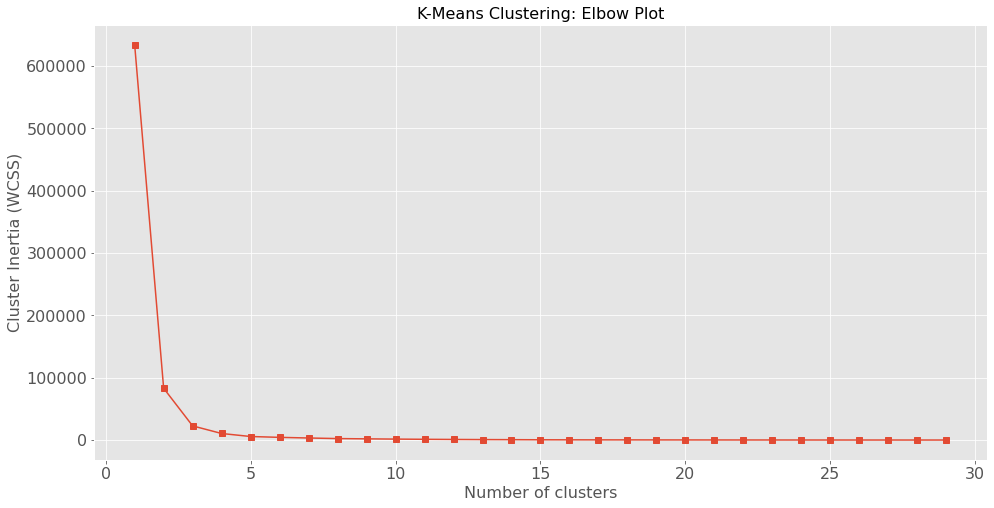

In [14]:
# Initiate the cluster inertia (WCSS) vector 
kmeans_interia = []

# Fit K-means model for different numbers of clusters
for ix_clusters in range(n_clusters_lb, n_clusters_ub):
    kmeans_model = KMeans(n_clusters=ix_clusters,
                          init=init_type,
                          n_init=n_init,
                          max_iter=max_iter,
                          random_state=1)
    kmeans_model.fit(df_final)
    kmeans_interia.append(kmeans_model.inertia_)

# Create the elbow plot
plt.figure(figsize=(16,8))    
plt.plot(range(n_clusters_lb,n_clusters_ub), kmeans_interia, marker='s')
plt.title('K-Means Clustering: Elbow Plot', size=16)
plt.xlabel('Number of clusters', size=16)
plt.ylabel('Cluster Inertia (WCSS)', size=16)
plt.xticks(size=16) 
plt.yticks(size=16)  
plt.show()

Based on the elbow plot for the above, we can see that WCSS score is rapidly falling. However, the scale is to large on the y axis. It turns out that we might pick something between 5-10 clusters.

The second approach is to calculate Average Silhouette Scores for model that has up to 30 clusters.

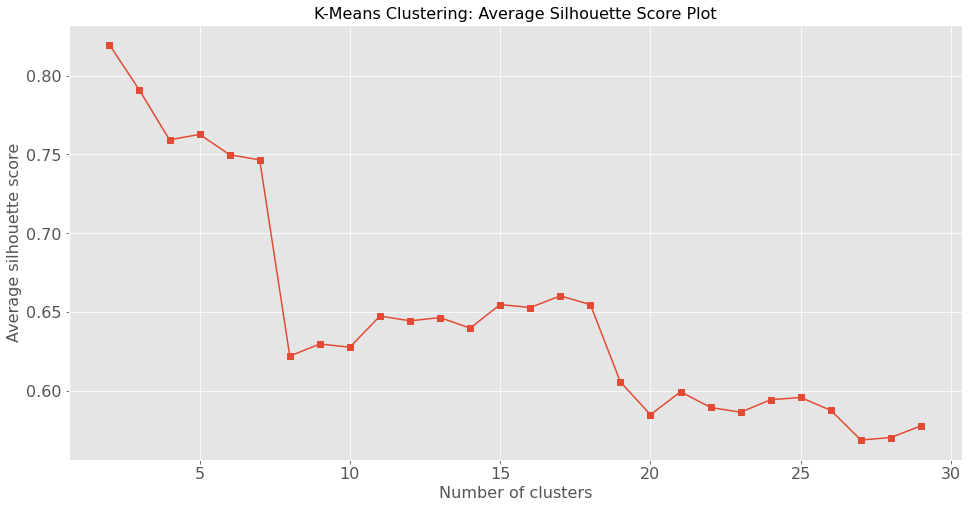

In [15]:
#Initiate the average silhouette score vector 
kmeans_silhouette_avg = []

# Fit K-means model for different numbers of clusters
for ix_clusters in range(n_clusters_lb+1, n_clusters_ub):
    kmeans_model = KMeans(n_clusters=ix_clusters,
                          init=init_type,
                          n_init=n_init,
                          max_iter=max_iter,
                          random_state=1)
    y_pred = kmeans_model.fit_predict(df_final)
    silhouette_vals = silhouette_samples(df_final, y_pred, metric='euclidean')
    kmeans_silhouette_avg.append(np.mean(silhouette_vals))

# Create the elbow plot
plt.figure(figsize=(16,8))    
plt.plot(range(n_clusters_lb+1,n_clusters_ub), kmeans_silhouette_avg, marker='s')
plt.title('K-Means Clustering: Average Silhouette Score Plot', size=16)
plt.xlabel('Number of clusters', size=16)
plt.ylabel('Average silhouette score', size=16)
plt.xticks(size=16) 
plt.yticks(size=16)  
plt.show()

The diagram above shows us that we can get pretty high scores if we pick something between 4 and 7 cluster. After 7th cluster, the Average Silhouette Score is dropping, so we will pick something in between - 6 clusters.

Now let's see the individual scores for each observation i.e. timeseries when we pick 6 clusters.

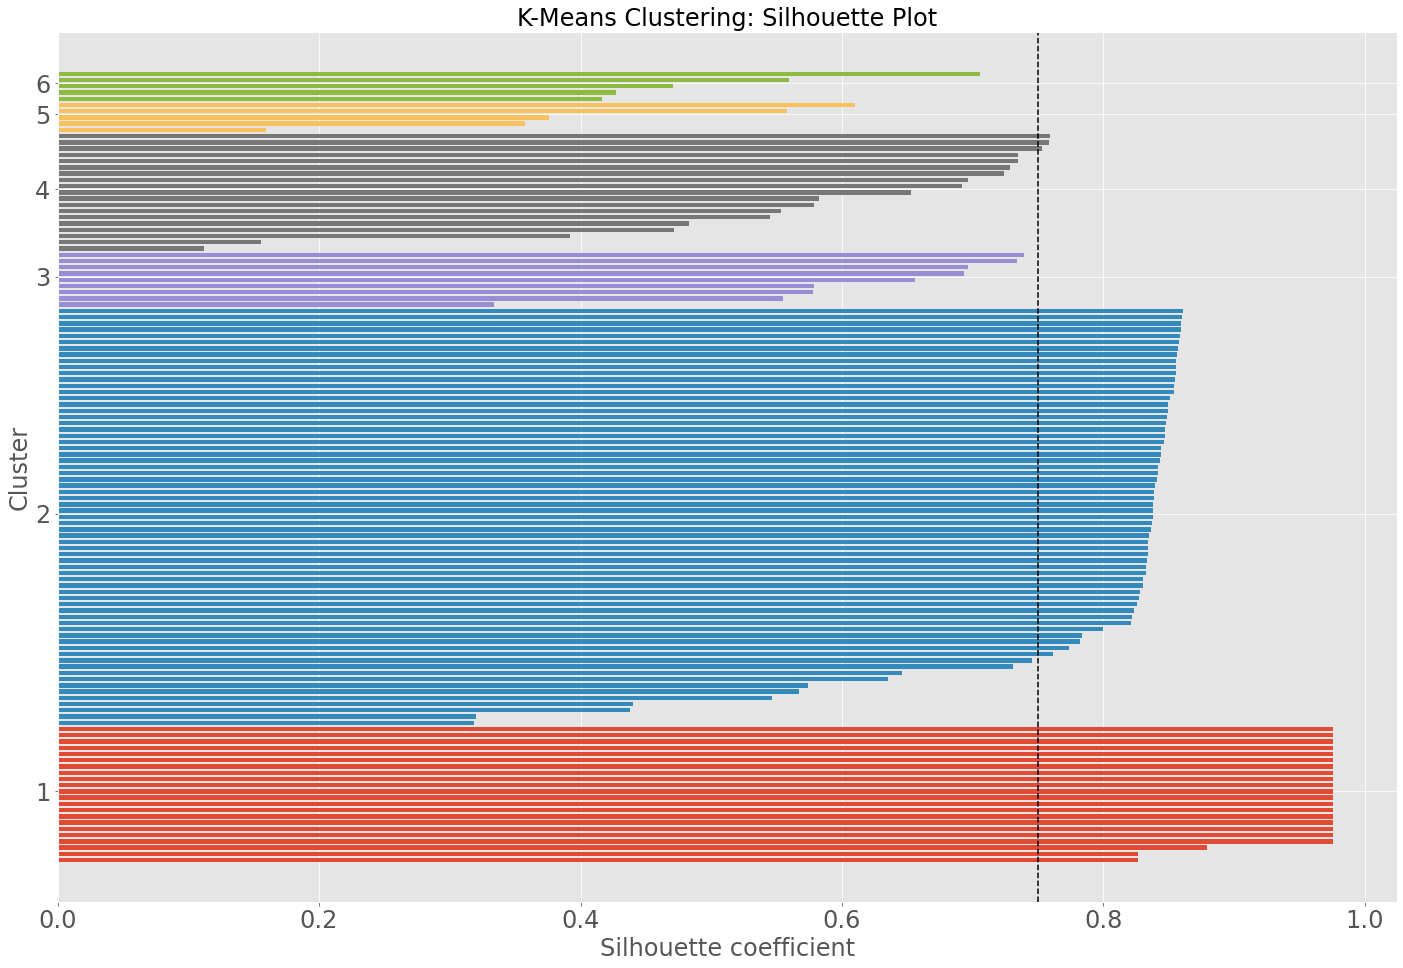

In [16]:
n_clusters = 6

# Create an instance of the class KMeans, fit the model, and predict cluster memberships
kmeans_model = KMeans(n_clusters=n_clusters,
                      init=init_type,
                      n_init=n_init,
                      max_iter=max_iter,
                      random_state=1)
y_pred = kmeans_model.fit_predict(df_final)

y_pred_kmeans = y_pred

# Retrieve and count unique clusters
kmeans_clusters = np.unique(y_pred)
n_clusters      = kmeans_clusters.shape[0]

# Calculate silhouette values for all samples
silhouette_vals = silhouette_samples(df_final, y_pred, metric='euclidean')

# Create the silhouette plot
plt.figure(figsize=(24,16)) 

y_ax_lower, y_ax_upper = 0, 0
yticks = []

for ix_clusters in kmeans_clusters:    
    c_silhouette_vals = silhouette_vals[y_pred == ix_clusters]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    plt.barh(range(y_ax_lower, y_ax_upper),
             c_silhouette_vals,
             height=0.7,
             edgecolor='none')
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg,
            color='k',
            linestyle='--')
plt.yticks(yticks, kmeans_clusters + 1)
plt.xticks(size=24) 
plt.yticks(size=24)
plt.title('K-Means Clustering: Silhouette Plot', size=24)
plt.ylabel('Cluster', size=24)
plt.xlabel('Silhouette coefficient', size=24)
plt.show()    

We can see that majority of the observation have good Silhouette coefficient, however, majority of observations are within second cluster.

### Gaussian Mixture Models

This algorithm requires setting the number of components, cluster in advance, so the first step is to calculate Average Silhouette Scores for model that has up to 30 clusters.

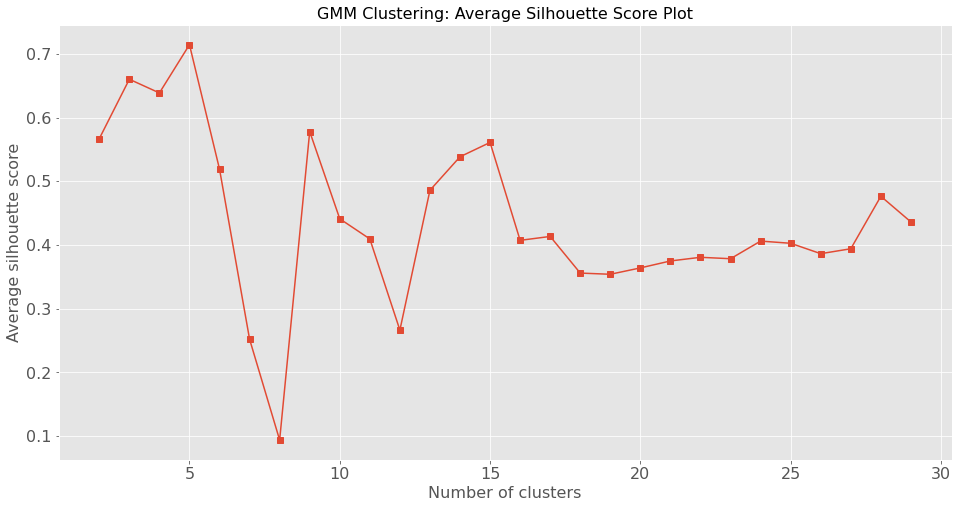

In [17]:
# Define the bounds for the number of clusters
n_clusters_lb = 2
n_clusters_ub = 30

# Initiate the average silhouette score vector 
gmm_silhouette_avg = []

# Fit K-means model for different numbers of clusters
for ix_clusters in range(n_clusters_lb, n_clusters_ub):
    gmm_model = GaussianMixture(n_components=ix_clusters,
                                n_init=10,
                                random_state=1)
    y_pred = gmm_model.fit_predict(df_final)
    silhouette_vals = silhouette_samples(df_final, y_pred, metric='euclidean')
    gmm_silhouette_avg.append(np.mean(silhouette_vals))

# Create the elbow plot
plt.figure(figsize=(16,8))    
plt.plot(range(n_clusters_lb,n_clusters_ub), gmm_silhouette_avg, marker='s')
plt.title('GMM Clustering: Average Silhouette Score Plot', size=16)
plt.xlabel('Number of clusters', size=16)
plt.ylabel('Average silhouette score', size=16)
plt.xticks(size=16) 
plt.yticks(size=16)  
plt.show()

From the graph above we can conclude that we get best score for 5 components/clusters. However, we also have good scores for 9 clusters, as well as 15 clusters.

We will pick 5 as it is the maximum, so let's see how individual observations fit in the clusters:

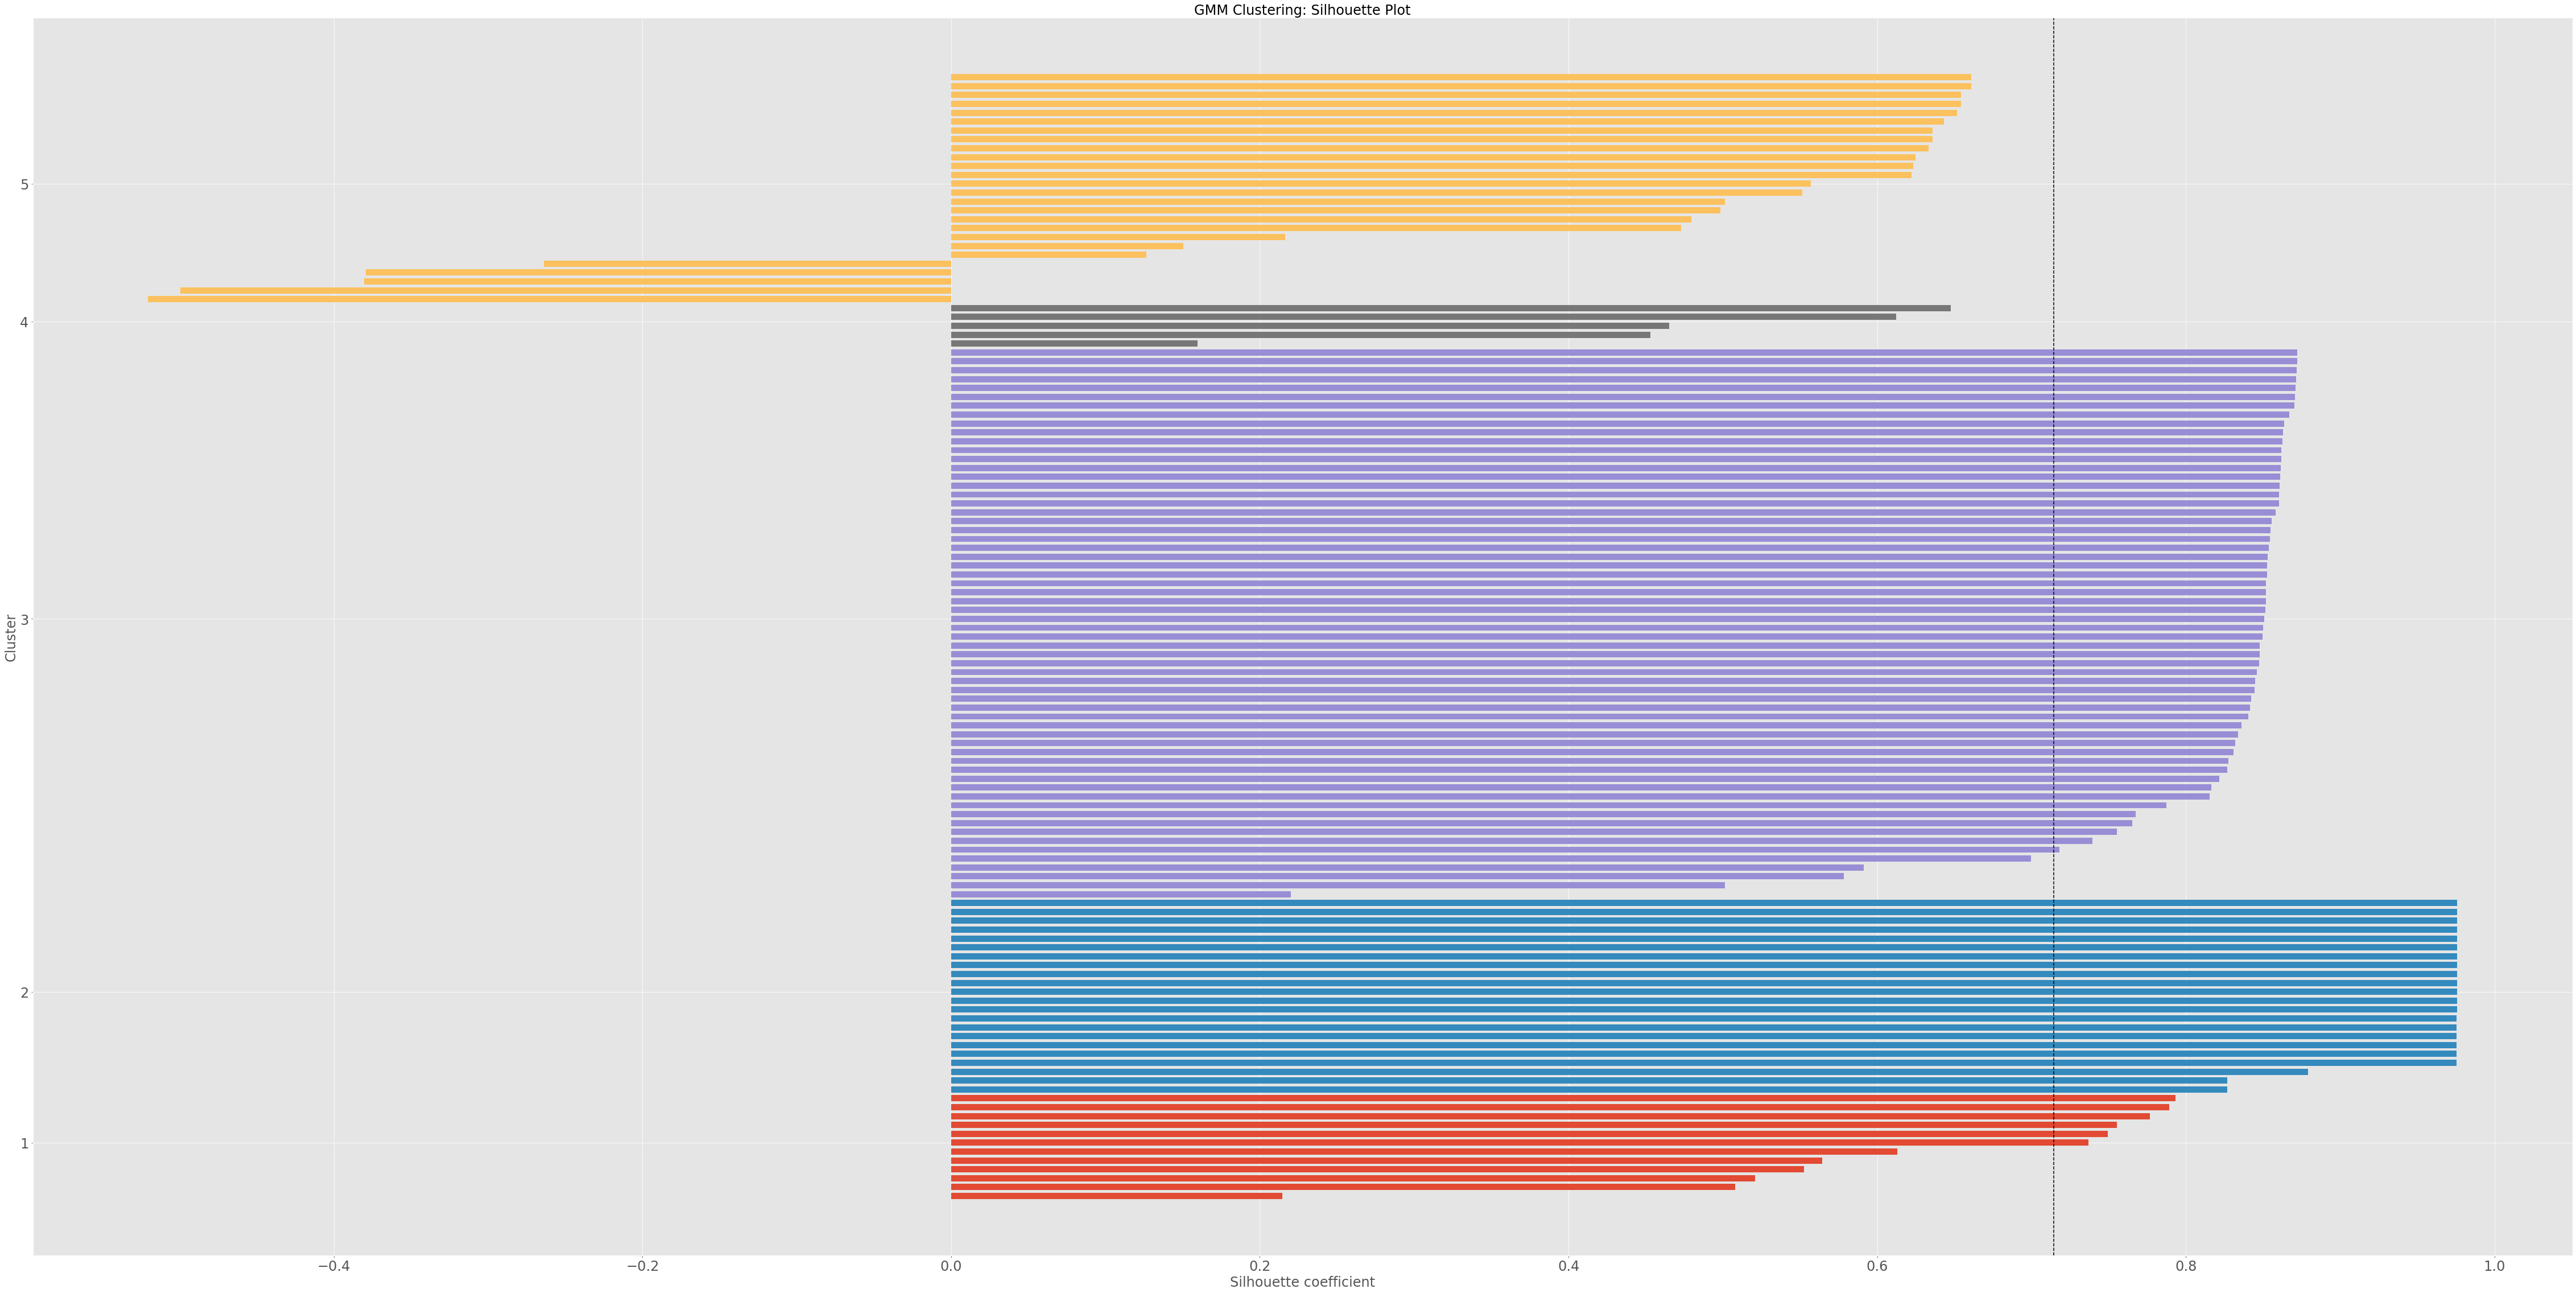

In [18]:
# Define the key inputs for the GMM
n_components = 5
n_init       = 10
random_state = 1

# Create an instance of the class GaussianMixture, fit the model, and predict the cluster membership
gmm_model = GaussianMixture(n_components=n_components,
                            n_init=n_init,
                            random_state=random_state)
y_pred = gmm_model.fit_predict(df_final)

y_pred_gmm = y_pred

# Retrieve and count unique clusters
gmm_clusters = np.unique(y_pred)
n_clusters   = gmm_clusters.shape[0]

# Calculate silhouette values for all samples
silhouette_vals = silhouette_samples(df_final, y_pred, metric='euclidean')

# Create the silhouette plot
plt.figure(figsize=(80,40)) 

y_ax_lower, y_ax_upper = 0, 0
yticks = []

for ix_clusters in gmm_clusters:    
    c_silhouette_vals = silhouette_vals[y_pred == ix_clusters]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    plt.barh(range(y_ax_lower, y_ax_upper),
             c_silhouette_vals,
             height=0.7,
             edgecolor='none')
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg,
            color='k',
            linestyle='--')
plt.yticks(yticks, gmm_clusters + 1)
plt.xticks(size=24) 
plt.yticks(size=24)
plt.title('GMM Clustering: Silhouette Plot', size=24)
plt.ylabel('Cluster', size=24)
plt.xlabel('Silhouette coefficient', size=24)
plt.show()

Well, we see that average score is good, but we have some observations that have negative score, which means that these samples are probably assigned to wrong clusters.

Now, let's take a look at Bayesian information criterion (BIC).
This criterion gives us an estimation on how much is good the GMM in terms of predicting the data we actually have. The lower is the BIC, the better is the model to actually predict the data we have, and by extension, the true, unknown, distribution. In order to avoid overfitting, this technique penalizes models with big number of clusters.

Best BIC score: -274.98
Optimal number of clusters: 12
----------------------------------------------------------------------------------------------------


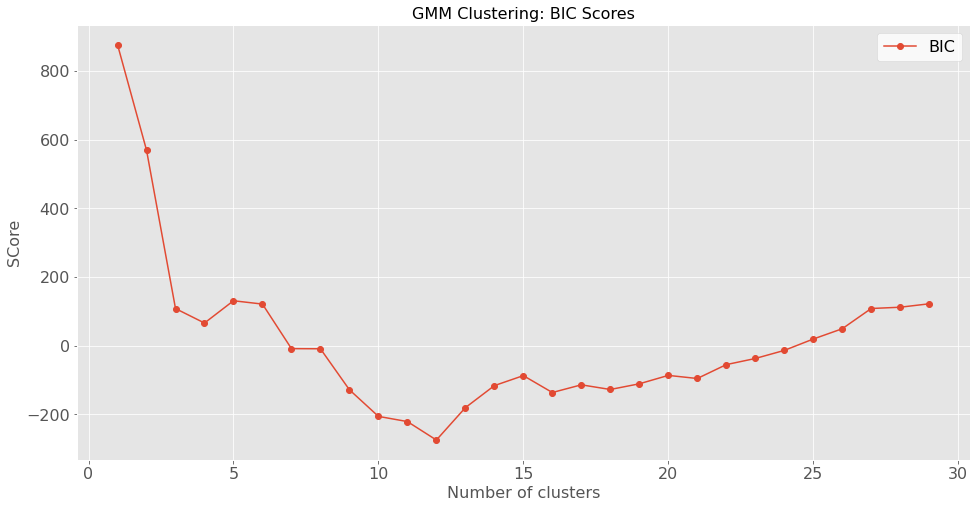

In [19]:
# Define the bounds for the number of clusters
n_clusters_lb = 1
n_clusters_ub = 30

# Initiate the vectors of BIC scores
gmm_bic = []

# Fit GMM model for different numbers of clusters
for ix_clusters in range(n_clusters_lb, n_clusters_ub):
    gmm_model = GaussianMixture(n_components=ix_clusters,
                                n_init=10,
                                random_state=1)
    gmm_model.fit(df_final)
    
    gmm_bic.append(gmm_model.bic(df_final))

# Display the key information       
print(f'Best BIC score: {round(min(gmm_bic),2)}')
print(f'Optimal number of clusters: {gmm_bic.index(min(gmm_bic))+1}') 
print(100*'-')
    
# Create the elbow plot
plt.figure(figsize=(16,8))    
plt.plot(range(n_clusters_lb,n_clusters_ub), gmm_bic, marker='o', label='BIC')
plt.legend(fontsize=16, facecolor='white')
plt.title('GMM Clustering: BIC Scores', size=16)
plt.xlabel('Number of clusters', size=16)
plt.ylabel('SCore', size=16)
plt.xticks(size=16) 
plt.yticks(size=16)  
plt.show()

The BIC score shows us that the optimal number of clusters is 12. However, our Average Silhouette Score showed us that 5 clusters give the best result, so GMM algorithm is not good for this dataset.

### Hierarchical Clustering Algorithm

Like in the previous two alrgothims, the challenge is to find the number of clasters. Let's draw the Average Silhouette Plot:

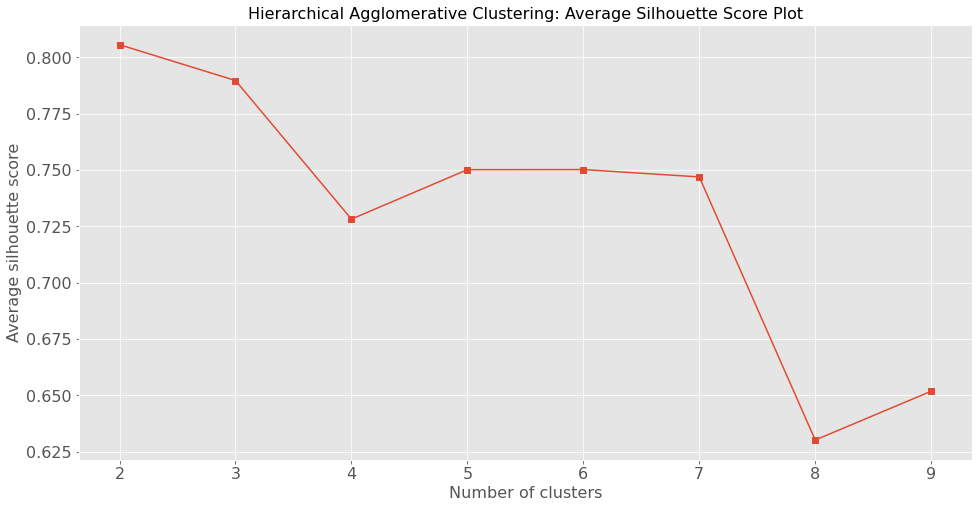

In [20]:
# Define the bounds for the number of clusters
n_clusters_lb = 2
n_clusters_ub = 10

# Initiate the average silhouette score vector 
hca_silhouette_avg = []

# Fit AgglomerativeClustering model for different numbers of clusters
for ix_clusters in range(n_clusters_lb, n_clusters_ub):
    hca_model = AgglomerativeClustering(n_clusters=ix_clusters,
                                        linkage='ward')
    y_pred = hca_model.fit_predict(df_final)
    silhouette_vals = silhouette_samples(df_final, y_pred, metric='euclidean')
    hca_silhouette_avg.append(np.mean(silhouette_vals))

# Create the elbow plot
plt.figure(figsize=(16,8))    
plt.plot(range(n_clusters_lb,n_clusters_ub), hca_silhouette_avg, marker='s')
plt.title('Hierarchical Agglomerative Clustering: Average Silhouette Score Plot', size=16)
plt.xlabel('Number of clusters', size=16)
plt.ylabel('Average silhouette score', size=16)
plt.xticks(size=16) 
plt.yticks(size=16)  
plt.show()

The best Average Silhouette score will be if we pick 3 clusters.

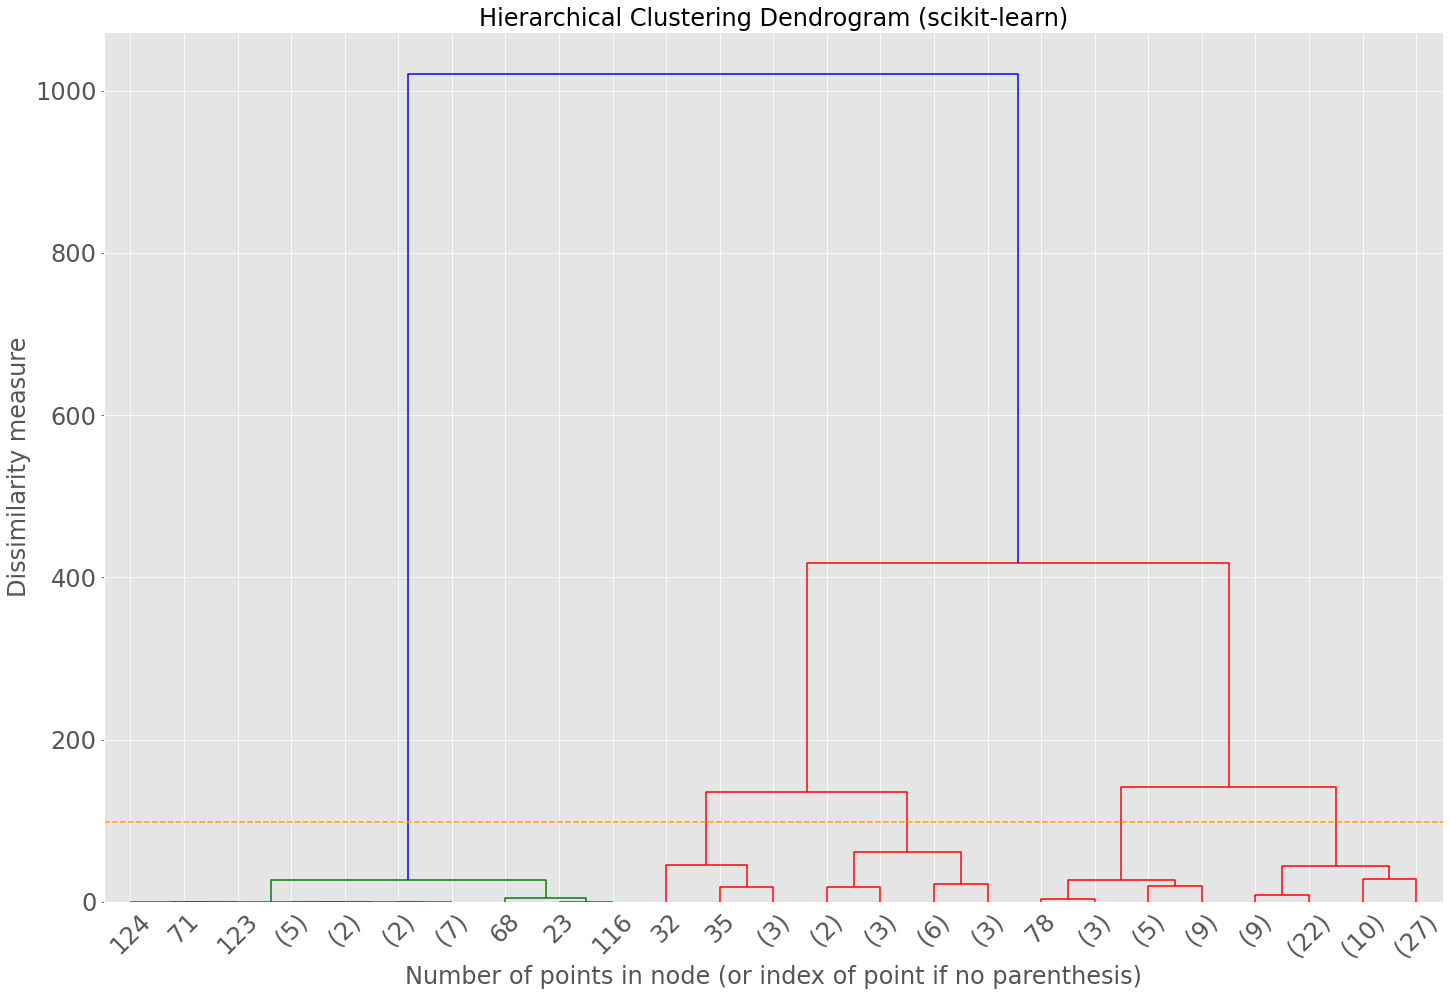

In [21]:
# Define the key inputs for the AgglomerativeClustering model
distance_threshold = 100
linkage_type       = 'ward' 

# Create an instance of the class AgglomerativeClustering and fit the model
hca_model = AgglomerativeClustering(linkage=linkage_type, 
                                    distance_threshold=distance_threshold, 
                                    n_clusters=None)

y_pred_hier = hca_model.fit_predict(df_final)
n_clusters = len(set(y_pred_hier))

# Prepare inputs for the linkage matrix
counts = np.zeros(hca_model.children_.shape[0])
n_samples = len(hca_model.labels_)

for i, children in enumerate(hca_model.children_):
    current_count = 0
    for ix_child in children:
        if ix_child < n_samples:
            current_count += 1  
        else:
            current_count += counts[ix_child - n_samples]
    counts[i] = current_count

# Compute the linkage matrix    
linkage_matrix = np.column_stack([hca_model.children_, hca_model.distances_, counts]).astype(float)

# Calculate the distance threshold (cut-off level) given the number of clusters
distances_sorted = np.sort(linkage_matrix[:,2])
distances_sorted = distances_sorted[::-1]
n_color_threshold  = 0.5 * (distances_sorted[n_clusters-2] + distances_sorted[n_clusters-1])

# Create a dendogram plot (and add the threshold line)
plt.figure(figsize=(24,16))
dendrogram(linkage_matrix, truncate_mode='level', p=4)
#dendrogram(linkage_matrix, truncate_mode='level', p=4, color_threshold=n_color_threshold, above_threshold_color='k')
plt.axhline(n_color_threshold, color='orange', linestyle='--')
plt.title('Hierarchical Clustering Dendrogram (scikit-learn)', size=24)
plt.xlabel('Number of points in node (or index of point if no parenthesis)', size=24)
plt.ylabel('Dissimilarity measure', size=24)
plt.xticks(size=24) 
plt.yticks(size=24)   
plt.show()

# Reset the color palette to the default values
set_link_color_palette(None)

### DBSCAN algorithm

The biggest challenge for DBSCAN algorithm is to find *eps* and *minPoints*. 

We will take minimum number of points (samples) twice as the dimension of our final dataset. The dimension is 4, therore the *minPoints* will be 8.

In [22]:
minPoints=8

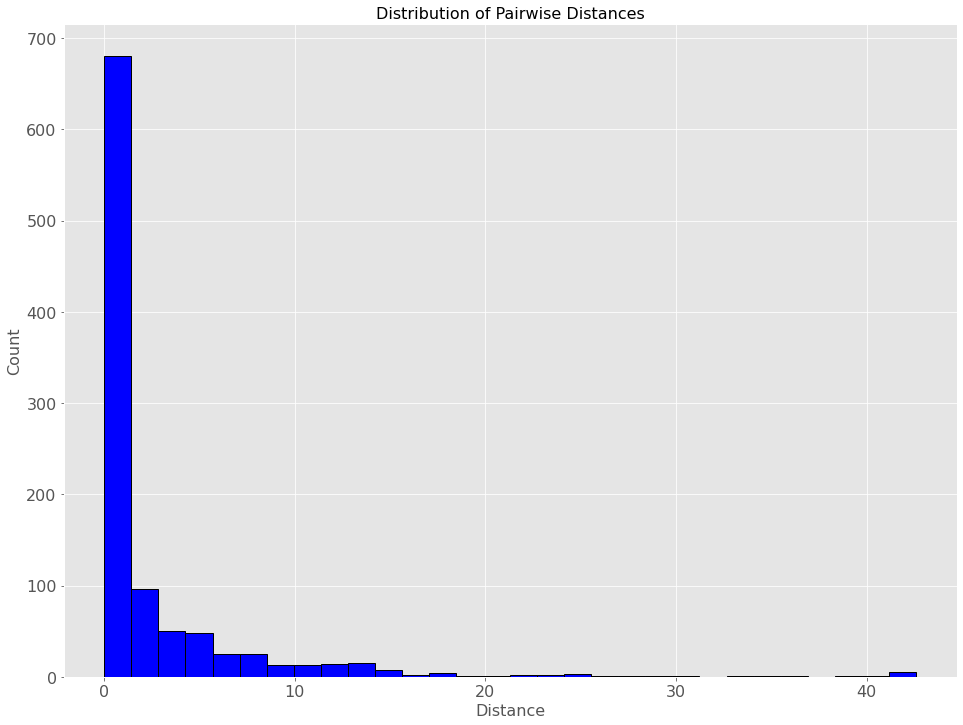

In [23]:
# Create an instance of the class NearestNeighbors and fit the model
nn_model  = NearestNeighbors(n_neighbors=minPoints, metric='euclidean')
neighbors = nn_model.fit(df_final)
distances, indices = neighbors.kneighbors(df_final)

# Plot the distribution of distances
plt.figure(figsize=(16,12)) 
plt.hist(distances.flatten(), bins=30, color='b', edgecolor='black', linewidth=1.0)
plt.title('Distribution of Pairwise Distances', size=16)
plt.xlabel('Distance', size=16)
plt.ylabel('Count', size=16)
plt.xticks(size=16) 
plt.yticks(size=16)
plt.show()

The idea is to calculate, the average of the distances of every point to its 8 nearest neighbors.

Next, these distances are plotted in ascending order. The aim is to determine the "knee", which corresponds to the optimal eps parameter.

A knee corresponds to a threshold where a sharp change occurs along the distance curve.

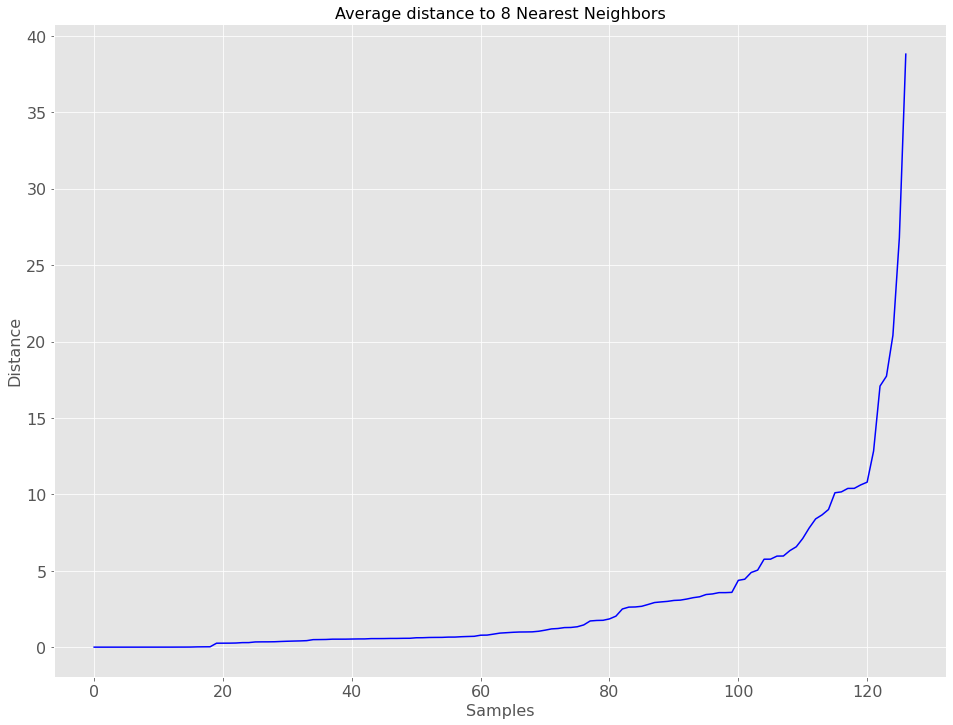

In [24]:
# Create an instance of the class NearestNeighbors and fit the model
n_neighbors = 8
nn_model    = NearestNeighbors(n_neighbors=n_neighbors, metric='euclidean')
neighbors   = nn_model.fit(df_final)

# Calcuate average distances to n_neighbors
distances, indices = neighbors.kneighbors(df_final)
distances_avg = distances[:, 1:].mean(axis=1)
distances_avg = np.sort(distances_avg, axis=0)

# Plot distances
plt.figure(figsize=(16,12))
plt.plot(distances_avg, color='b')
plt.title('Average distance to ' + str(n_neighbors) + ' Nearest Neighbors', size=16)
plt.xlabel('Samples', size=16)
plt.ylabel('Distance', size=16)
plt.xticks(size=16) 
plt.yticks(size=16)  
plt.show()

Based on the plot above, we can see that we should pick between 5 and 15 for the *eps* value. 

Let's start with *eps*=5.

In [25]:
# Compute DBSCAN
db = DBSCAN(eps=5, min_samples=8).fit(df_final)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(df_final, labels))

Estimated number of clusters: 3
Estimated number of noise points: 25
Silhouette Coefficient: 0.620


The result shows us that Silhouette Coefficient is 0.62 which is ok. Algorithm has identified 3 clusters and 25/127 outliers.

Let's try to find optimal *eps* and *min_samples*.

In [26]:
# Define the bounds for the number of clusters
eps_lb   = 5
eps_ub   = 15
eps_step = 0.1

min_samples_lb   = 5
min_samples_ub   = 25
min_samples_step = 1

# Fit DBSCAN model for different eps and min_samples values
dbscan_output = []

for ix_eps in np.arange(eps_lb, eps_ub, eps_step):
    dbscan_silhouette_avg_vec = []
    
    for ix_min_samples in np.arange(min_samples_lb, min_samples_ub, min_samples_step):
        dbscan_model = DBSCAN(eps=ix_eps,
                              min_samples=ix_min_samples)
        y_pred = dbscan_model.fit_predict(df_final)
        
        dbscan_silhouette_vals = silhouette_samples(df_final, y_pred, metric='euclidean')
        dbscan_silhouette_avg_vec.append(np.mean(dbscan_silhouette_vals))
        
        dbscan_output.append((ix_min_samples, ix_eps, np.mean(dbscan_silhouette_vals)))
        
    dbscan_silhouette_avg_vec = np.array(dbscan_silhouette_avg_vec)
    
    if ix_eps == eps_lb:
        dbscan_silhouette_avg_mat = dbscan_silhouette_avg_vec
    else:
        dbscan_silhouette_avg_mat = np.vstack((dbscan_silhouette_avg_mat, dbscan_silhouette_avg_vec))

# Display the key information       
optimal_min_samples, optimal_eps, max_silhouette_avg = sorted(dbscan_output, key=lambda x:x[-1])[-1]
print(f'Best silhouette_score: {round(max_silhouette_avg,2)}')
print(f'Optimal min_samples: {optimal_min_samples}')
print(f'Optimal eps: {round(optimal_eps,2)}')  

labels = DBSCAN(min_samples=optimal_min_samples, eps = optimal_eps).fit(df_final).labels_
clusters = len(Counter(labels))
print(f'Number of clusters: {clusters}')
print(f'Number of outliers: {Counter(labels)[-1]}')
print(100*'-')


Best silhouette_score: 0.79
Optimal min_samples: 18
Optimal eps: 14.9
Number of clusters: 3
Number of outliers: 17
----------------------------------------------------------------------------------------------------


Now we have the optimal values for *eps* and *min_samples*. The Silhouette score is 0.79 which is a really good score.

In [27]:
dbscan_model = DBSCAN(eps=14.9,
                      min_samples=18)
y_pred_dbscan = dbscan_model.fit_predict(df_final)


- Discuss your modeling choices and findings.

**NOTE**: All choices and findings are explained above, each algorithm separately.

## (c) Final output

Try to consolidate (quantitatively or qualitatively) the results you
have obtained using different algorithms and to come up with a final clustering proposal. Discuss the similarities and differences between your clustering results and the classification of the macroeconomic variables provided in McCracken and Ng (2016).
(5 pts)

In this section, we will provide two summary table. The first one will be the Average Silhouette Scores and number of clusters. Let's take a look:

| Algorithm | Number of Clusters | Average Silhouette Score |
| --- | --- | --- |
| K-means | 6 | 0.75 |
| Gaussian Mixture Models | 5 | 0.71 |
| Hiearchical | 3 | 0.79 |
| DBSCAN | 3 | 0.79 |

Second table will be all timeseries (observations) and what cluster they belong to in every output that we got in the previous sections.


In [28]:
cluster_table = pd.DataFrame(index=df_final.index)
cluster_table.insert(0, "K-means", y_pred_kmeans, True)
cluster_table.insert(1, "GMM", y_pred_gmm, True)
cluster_table.insert(2, "Hierarchical", y_pred_hier, True)
cluster_table.insert(3, "DBSCAN", y_pred_dbscan, True)
cluster_table

,K-means,GMM,Hierarchical,DBSCAN
RPI,0,1,4,0
W875RX1,0,1,4,0
DPCERA3M086SBEA,0,1,4,0
CMRMTSPLx,0,1,4,0
RETAILx,3,4,3,1
...,...,...,...,...
UMCSENTx,1,2,2,1
DTCOLNVHFNM,0,1,4,0
DTCTHFNM,0,1,4,0
INVEST,1,2,2,1
